https://r-bloggers.com/2015/03/matrix-factorization/

https://files.grouplens.org/datasets/movielens/

## USAR PYTHON 3.10.11

In [41]:
%pip install pandas numpy scikit-surprise matplotlib scikit-learn scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from math import sqrt
from scipy.optimize import minimize

from sklearn.metrics import roc_curve, auc, mean_squared_error

from surprise import Dataset, Reader, NormalPredictor, KNNBasic, SVD, AlgoBase, accuracy
from surprise.model_selection import train_test_split, KFold

GLOBAL_RANDOM = 42
GLOBAL_RATING_THRESHOLD = 4.0

np.random.seed(GLOBAL_RANDOM)

In [62]:
movies_df = pd.read_csv('./ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv')
links_df = pd.read_csv('./ml-latest-small/links.csv')
tags_df = pd.read_csv('./ml-latest-small/tags.csv')

In [63]:
# Carga del conjunto de datos de calificaciones de películas
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv')

# Reindexación de usuarios y películas para comenzar en cero, facilitando el manejo de matrices
ratings_df['userId'] = pd.factorize(ratings_df['userId'])[0]
ratings_df['movieId'] = pd.factorize(ratings_df['movieId'])[0]

# Creación de una matriz de calificaciones con usuarios en filas y películas en columnas
ratings_pivot = ratings_df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Extracción de dimensiones del conjunto de datos para su uso en la matriz de factorización
num_users = ratings_pivot.shape[0]
num_movies = ratings_pivot.shape[1]

# Conversión de la matriz de calificaciones a una matriz NumPy para cálculos
R = ratings_pivot.to_numpy()
# Creación de una matriz binaria que indica si una calificación fue proporcionada
Y = np.where(R > 0, 1, 0)

# Establecimiento de número de características latentes para la factorización
num_features = 10
# Inicialización aleatoria de las matrices de características para películas y usuarios
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)

# Definición de la función de costo para minimizar
def cost_function(params, Y, R, num_users, num_movies, num_features, lambda_reg):
    # Reconstrucción de las matrices X y Theta a partir del vector de parámetros
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Predicción de calificaciones mediante el producto de matrices
    prediction = X.dot(Theta.T)
    # Cálculo del error ponderado solo por calificaciones existentes
    error = (prediction - Y.T) * R.T
    # Cálculo del costo total incluyendo término de regularización
    cost = 0.5 * np.sum(error**2) + (lambda_reg/2.) * (np.sum(Theta**2) + np.sum(X**2))

    print("Cost:", cost)  # Impresión del costo para seguimiento
    return cost

# Definición de la función de gradiente para el optimizador
def gradient(params, Y, R, num_users, num_movies, num_features, lambda_reg):
    # Reconstrucción de las matrices desde los parámetros
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Predicción y cálculo del error
    prediction = X.dot(Theta.T)
    error = (prediction - Y.T) * R.T
    # Cálculo de gradientes para X y Theta con regularización
    X_grad = error.dot(Theta) + lambda_reg * X
    Theta_grad = error.T.dot(X) + lambda_reg * Theta
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    print("Grad norm:", np.linalg.norm(grad))  # Impresión de la norma del gradiente para seguimiento
    return grad

# Normalización de parámetros iniciales para mejorar la estabilidad de la optimización
initial_params = np.random.randn(num_movies * num_features + num_users * num_features)
initial_params /= np.linalg.norm(initial_params)
lambda_reg = 10.0  # Coeficiente de regularización

# Configuración del optimizador
options = {'maxiter': 1000, 'disp': True, 'gtol': 1e-5}
# Ejecución de la optimización
result = minimize(fun=cost_function, x0=initial_params, args=(Y, R, num_users, num_movies, num_features, lambda_reg), jac=gradient, method='L-BFGS-B', options=options)

# Impresión de resultados de la optimización
print("Optimization success:", result.success)
print("Message:", result.message)

# Cálculo de predicciones finales usando los parámetros optimizados
X_opt = result.x[:num_movies * num_features].reshape(num_movies, num_features)
Theta_opt = result.x[num_movies * num_features:].reshape(num_users, num_features)
predictions = X_opt.dot(Theta_opt.T)

# Cálculo del RMSE para evaluar el rendimiento del modelo
mask = R > 0  # Máscara para seleccionar las entradas con calificaciones originales
predicted_ratings = predictions.T[mask]
actual_ratings = R[mask]
rmse_matrix_fact = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print("RMSE - Matrix Factorization:", rmse_matrix_fact)


Cost: 672972.2967410893
Grad norm: 18.981716589222724
Cost: 672938.4461643569
Grad norm: 214.5364774975583
Cost: 672814.2562727407
Grad norm: 394.4698309625961
Cost: 671461.6626568668
Grad norm: 1118.5700277715584
Cost: 655753.5030296358
Grad norm: 3846.453848240549
Cost: 1244462.7961143006
Grad norm: 21949.186417296045
Cost: 655337.4880870783
Grad norm: 3899.8463359002335
Cost: 655324.5148320794
Grad norm: 3901.5100220235145
Cost: 685613.8794095304
Grad norm: 8635.558993435548
Cost: 652809.8062506599
Grad norm: 4224.4587342709
Cost: 652740.5987861616
Grad norm: 4233.41382332896
Cost: 644592.3492797324
Grad norm: 6333.238446117001
Cost: 647318.8980951407
Grad norm: 4991.780028991378
Cost: 644073.8085716657
Grad norm: 6160.112780656817
Cost: 643986.2372773103
Grad norm: 6111.074088853966
Cost: 644549.6762209819
Grad norm: 5559.408427210002
Cost: 643896.9092118036
Grad norm: 6031.446366342385
Cost: 663646.4951152196
Grad norm: 2286.4741359134377
Cost: 643492.0807671775
Grad norm: 5840.43

In [64]:
class PopularRecommender(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        ratings = defaultdict(list)
        for (uid, iid, rating) in trainset.all_ratings():
            ratings[iid].append(rating)
        self.avg_rating = {trainset.to_raw_iid(i): np.mean(ratings[i]) for i in ratings}
        return self

    def estimate(self, u, i):
        try:
            if self.trainset.knows_item(i):
                return self.avg_rating[self.trainset.to_raw_iid(i)]
            else:
                raise PredictionImpossible('Item not in training data')
        except KeyError:
            return self.trainset.global_mean

In [65]:
# Creación de los modelos
models = {
    "Random": NormalPredictor(),
    "Popular": PopularRecommender(),  # Asegúrate de que esta clase esté definida como mostré anteriormente
    "User-Based CF": KNNBasic(sim_options={'user_based': True}),
    "Item-Based CF": KNNBasic(sim_options={'user_based': False}),
    "Matrix Factorization": SVD(random_state=GLOBAL_RANDOM)
}

RMSE: 1.4303
RMSE: 0.9771
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9488
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9050
RMSE: 0.8743
RMSE: 1.4263
RMSE: 0.9717
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9430
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9098
RMSE: 0.8735
RMSE: 1.4240
RMSE: 0.9778
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9499
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9100
RMSE: 0.8776
RMSE: 1.4189
RMSE: 0.9868
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9576
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9149
RMSE: 0.8789
RMSE: 1.4345
RMSE: 0.9706
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9416
Computing the msd similarity matrix...
Done 

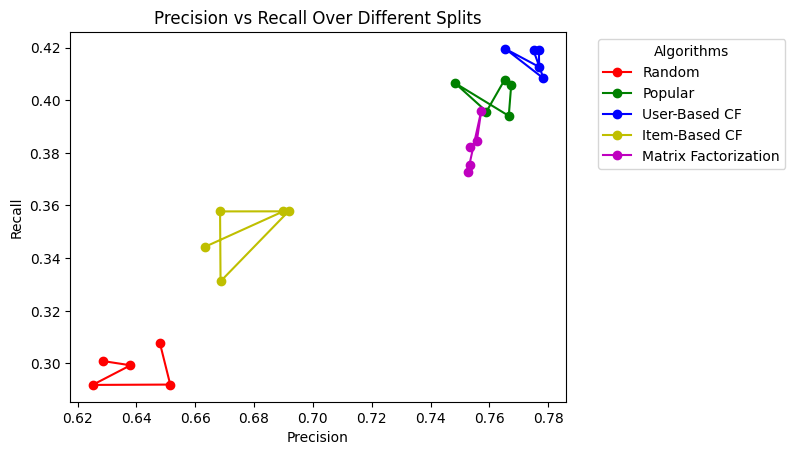

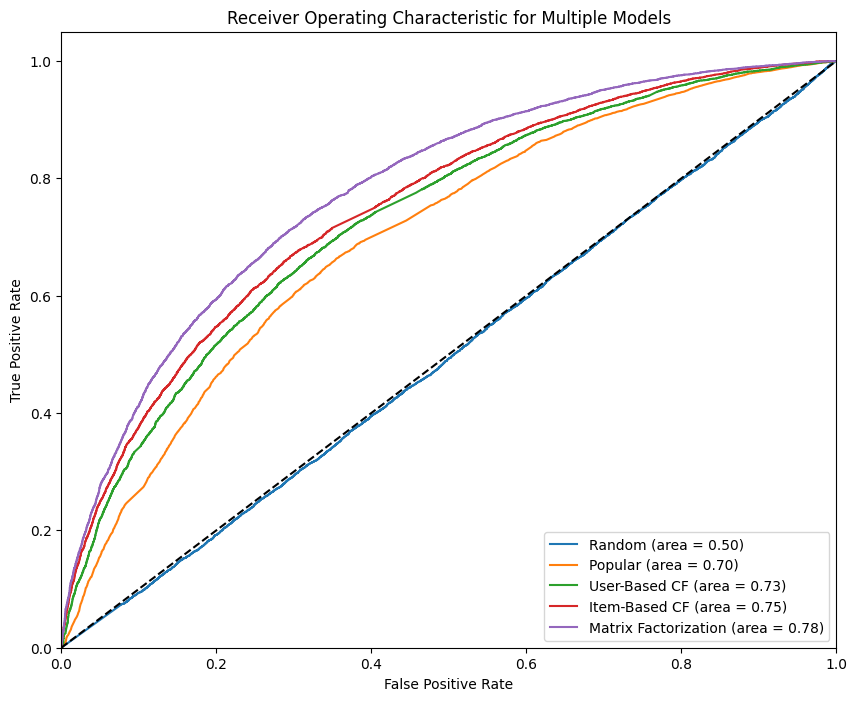

RMSE - Random: 1.4345348889006975
RMSE - Popular: 0.9706458831004552
RMSE - User-Based CF: 0.9416228173993245
RMSE - Item-Based CF: 0.903357245737388
RMSE - Matrix Factorization: 0.8696868664427498


In [66]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Preparar la evaluación cruzada
kf = KFold(n_splits=5)
precision_recall_results = defaultdict(list)
roc_results = {}
rmse_results = {}

# Ejecutar evaluación cruzada para todos los algoritmos
for i, (trainset, testset) in enumerate(kf.split(data)):
    for name, model in models.items():
        # Entrenamiento y predicción con cada modelo
        model.fit(trainset)
        predictions = model.test(testset)
        
        # Cálculo para curvas de precisión y recall
        precisions, recalls = precision_recall_at_k(predictions, k=5)
        mean_prec = np.mean(list(precisions.values()))
        mean_rec = np.mean(list(recalls.values()))
        precision_recall_results[name].append((mean_prec, mean_rec))
        
        # Preparación de datos para la curva ROC
        y_real = np.array([pred.r_ui for pred in predictions])
        y_scores = np.array([pred.est for pred in predictions])
        y_real_binary = (y_real >= GLOBAL_RATING_THRESHOLD).astype(int)
        fpr, tpr, _ = roc_curve(y_real_binary, y_scores)
        roc_auc = auc(fpr, tpr)
        roc_results[name] = (fpr, tpr, roc_auc)
        
        # Cálculo del RMSE
        rmse_results[name] = accuracy.rmse(predictions)

# Visualización de los resultados de precisión y recall
fig, ax = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'm']  # Colores para los diferentes algoritmos
for name, points in precision_recall_results.items():
    if points:
        xs, ys = zip(*points) if len(points) > 1 else ([points[0][0]], [points[0][1]])
        ax.plot(xs, ys, marker='o', linestyle='-', color=colors.pop(0), label=name)

ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision vs Recall Over Different Splits')
ax.legend(title="Algorithms", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualización de las curvas ROC para cada modelo
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiple Models')
plt.legend(loc="lower right")
plt.show()

# Impresión de los resultados de RMSE
for name, rmse_value in rmse_results.items():
    print(f"RMSE - {name}: {rmse_value}")

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import Dataset
from surprise import Reader
import pickle

# Carga de datos
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Definir la rejilla de parámetros a explorar
param_grid = {'n_factors': [50, 100, 150],  # Número de factores latentes
              'n_epochs': [20, 30, 40],       # Número de épocas de entrenamiento
              'lr_all': [0.005, 0.01, 0.02],  # Tasa de aprendizaje para todos los parámetros
              'reg_all': [0.02, 0.04, 0.06]}  # Término de regularización para todos los parámetros

# Inicializar el modelo SVD
svd = SVD(random_state=42)

# Configurar la búsqueda de hiperparámetros
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Nombre del archivo para guardar los resultados
filename = 'grid_search_results.pkl'

try:
    # Intentar cargar los resultados desde el archivo
    with open(filename, 'rb') as f:
        grid_search_results = pickle.load(f)
    print("Resultados de la búsqueda de hiperparámetros cargados desde el archivo.")

except FileNotFoundError:
    # Ejecutar la búsqueda de hiperparámetros si el archivo no existe
    print("No se encontraron resultados previos. Ejecutando la búsqueda de hiperparámetros...")
    gs.fit(data)
    
    # Guardar los resultados en el archivo
    with open(filename, 'wb') as f:
        pickle.dump(gs.cv_results, f)
    print("Resultados de la búsqueda de hiperparámetros guardados en el archivo.")

# Obtener los mejores resultados
print("Mejor RMSE:", grid_search_results.best_score['rmse'])
print("Mejores hiperparámetros:", grid_search_results.best_params['rmse'])
